# 04-Equations to Solve Problems
Solving systems of equations is a common task in engineering.  In this section, we'll review how to solve systems of equations using Python with multiple different approaches. The exampels will come from evaluating mass balances on a processing system.

## Solving Linear Systems of Equations
Separation process principles are critical to many industries. Lets say you have a flashing unit that is separating a mixture of benzene and toluene.  The feed to the unit is 40 mol% benzene and 60 mol% toluene.  The vapor leaving the unit is 80 mol% benzene and 20 mol% toluene.  The liquid leaving the unit is 10 mol% benzene and 90 mol% toluene.  The feed rate is 100 mol/hr.  The vapor and liquid leaving the unit are in equilibrium.  What are the flow rates of the vapor and liquid leaving the unit?

This problem can be solved by writing a system of equations and solving for the unknowns.  In this case, we have two unknowns, the vapor and liquid flow rates.  We can write two equations, one for the benzene balance and one for the total flows. One of the equations would be a species balance and the other equation a total mass balance. A picture of the system is shown below.


<img src=supportfiles/flashingunitbasic.png width="200">

The inlet enters at the left and the vapor exists the top and the liquid exists the bottom. This is equivalent to a single stage of a distillation column.  The equations are:

$$
\begin{align}
F &= L + V \\
z_i F &= x_i L + y_i V
\end{align}
$$

which for this case $z_i$ = 0.4, $F$ = 100 mol/hr, $x_i$ = 0.1, $y_i$ = 0.8. We can solve this in many different ways. We'll solve this system of equations multiple ways:
- first we'll do it using SymPy,
- then we'll do it using NumPy,
- then we'll do it using SciPy,
- then we'll do it using Gauss Elimination,
- and with Gekko (a software package for dynamic optimization).

Of course this simple set could be rearranged and solved algebraically.


### Solve Linear System with Sympy
The above equations can be solved symbolically as shown below using the sympy package. 

In [1]:
import sympy as sym
from IPython.display import display, Math
L = sym.symbols('L')
V = sym.symbols('V')
ans = sym.solve([100 - (L+V), 0.4*100-0.1*L-0.8*V], [L,V])
#or equiavlently you can use 
#ans = sym.linsolve([100 - (L+V), 0.4*100-0.1*L-0.8*V],[L,V])
display(Math(sym.latex(ans)))

<IPython.core.display.Math object>

### Solve Linear System with Numpy
The above equations can be solved numerically as shown below using the numpy package. First you'll adjust the equations algebraically to be in the form Ax = b.  Then you'll use the numpy.linalg.solve function to solve the system of equations.

The above equation rearranged into the form Ax = b is:

$$
\begin{align}
L + V &= 100 \\
0.1 L + 0.8 V &= 40
\end{align}
$$

The A matrix is:

$$
\begin{bmatrix}
1 & 1 \\
0.1 & 0.8
\end{bmatrix}
$$

and the b vector is:

$$
\begin{bmatrix}
100 \\
40
\end{bmatrix}
$$

In [2]:
import numpy as np
A = np.array([[1,1],[0.1,0.8]])
b = np.array([100,40])

x = np.linalg.solve(A,b)
print(f'The solution is {x} for the system of equations with the first value equal to L and the second value equal to V')

The solution is [57.14285714 42.85714286] for the system of equations with the first value equal to L and the second value equal to V


### Solve Linear System with Scipy
The above equations can be solved numerically as shown below using the scipy package. Fsolve can be used to solve for multiple variables in both a non-linear and linear scenario given there are continuous functions and the number of equations = number of unknowns.

In [3]:
from scipy.optimize import fsolve
def equations(p):
    L,V = p
    return (100 - (L+V), 0.4*100-0.1*L-0.8*V) #each equation is set so that it is equal to zero, also the returned value is also a tuple

L,V =  fsolve(equations, (1,1))
print(f'The solution is {L:0.2f} for L and {V:0.2f} for V')

The solution is 57.14 for L and 42.86 for V


### Solve Linear System with Gaussian Elimination
Linear algebra techniques can be used to take the inverse of the A matrix and multiply it by the b vector to solve for the unknowns.  One way to get the inverse of the A matrix is to use the Gauss Elimination method.  This method is shown below. Similar to the linalg solution above, the system of equations are arranged in the form Ax = b.

In [4]:
import numpy as np

# Define the augmented matrix [A|b]
A = np.array([[1, 1],
                [0.1, 0.8]])

b = np.array([100, 40])

# Augmented matrix dimensions
n_rows, n_cols = A.shape

# Forward elimination
for k in range(n_rows - 1):
    for i in range(k + 1, n_rows):
        factor = A[i, k] / A[k, k]
        A[i, k:] -= factor * A[k, k:]
        b[i] -= factor * b[k]

# Back substitution
x = np.zeros(n_rows)
for i in range(n_rows - 1, -1, -1):
    x[i] = (b[i] - np.dot(A[i, i+1:], x[i+1:])) / A[i, i]

print("Solution:")
print(x)

Solution:
[57.14285714 42.85714286]


In [5]:
#Solve equation with Gekko
from gekko import GEKKO
m = GEKKO() # Initialize gekko
L = m.Var(value=1) # Initialize variables
V = m.Var(value=1)
m.Equations([L+V==100,0.1*L+0.8*V==40]) # Equations
m.solve(disp=False) # Solve
print(f'The solution is {L.value[0]:0.2f} for L and {V.value[0]:0.2f} for V')

The solution is 57.14 for L and 42.86 for V


The above answers are consistent with the answers from the other methods.

## Solving Non-Linear Systems of Equations
Similar tools can be used to solve non-linear systems of equations. Scipy's fsolve is commonly used. There are other tools including Gekko, and Newton's method.

One application of solving a non-linear equatoin in chemical engineering is calculating the pressure loss from flow down a pipe using the Colbrook equation to determine the Darcy friction factor.  The Darcy friction factor is used to calculate the pressure drop in a pipe.  The Darcy friction factor is a function of the Reynolds number and the relative roughness of the pipe.  The Reynolds number is a function of the fluid velocity, density, viscosity, and pipe diameter.  

In [6]:
#Colebrook equation, Re is Reynolds number, D is pipe diameter, epsilon is the pipe roughness
def Colbrook(f,Re,D,epsil):
    return 1/np.sqrt(f) + 2*np.log10(2.51/(Re*np.sqrt(f))+epsil/(3.71*D)) 

The Colbrook equation is:

$$
\begin{equation}
\frac{1}{\sqrt{f}} = -2.0 \log_{10} \left( \frac{\epsilon/D}{3.71} + \frac{2.51}{\text{Re} \sqrt{f}} \right)
\end{equation}
$$

where $f$ is the darcy friction factor, $\epsilon$ is the pipe roughness, $D$ is the pipe diameter, and Re is the Reynolds number equal to the product of the fluid density, velocity, and diameter divided by the fluid viscosity. This is valid with a relative roughness of $\epsilon/D < 0.05$ and $10^4 < \text{Re} < 10^8$.

The pressure loss down the length of pipe is calculated by:

$$
\begin{equation}
\Delta P = f \frac{L}{D} \frac{\rho v^2}{2}
\end{equation}
$$

where $\Delta P$ is the pressure drop, $f$ is the Darcy friction factor, $L$ is the length of the pipe, $D$ is the pipe diameter, $\rho$ is the fluid density, and $v$ is the fluid velocity.

In [7]:
#pressure loss down a length of pipe in terms of the friction factor
def pressure_loss(f,L,D,rho,v):
    return f*L/D*rho*v**2/2

Example problem: calculate the pressure drop down a 100 m long pipe with a 2 inch diameter with a fluid velocity of 1 m/s.  The fluid has a density of 1000 kg/m$^3$ and a viscosity of 0.001 kg/m-s.  The pipe roughness is 0.0001 m.  What is the pressure drop?

### Non-linear solution with scipy fsolve

In [8]:
#first calculate the Reynolds number
def Reynolds(rho,v,D,mu):
    return rho*v*D/mu
#specify pressure losses
def pressure_loss(f,L,D,rho,v):
    return f*L/D*rho*v**2/2
#set constants
rho = 1000 #kg/m^3
vel = 1 #m/s
pipeDia = 2*0.0254 #inch to m
mu = 0.001 #Pa*s
epsil = 0.0001 #m
pipeLen = 100 #m
#solve for the friction factor
from scipy.optimize import fsolve
f =  fsolve(lambda f: Colbrook(f,Reynolds(rho,vel,pipeDia,mu),pipeDia,epsil), 0.01)[0]
#calculate the pressure drop
ploss = pressure_loss(f,pipeLen,pipeDia,rho,vel) #Pa
print(f'The Reynolds number is {Reynolds(rho,vel,pipeDia,mu):.0f}')
print(f'The friction factor is {f:.4f}')
print(f'The pressure drop is {ploss/1000:.2f} Pa (or {ploss/1000*0.145:.2f} psi)')



The Reynolds number is 50800
The friction factor is 0.0264
The pressure drop is 25.97 Pa (or 3.76 psi)


### Non-linear solution with Gekko
Solve for the friction factor using the GEKKO package.

In [9]:
#Solve for the friction factor using Gekko
m = GEKKO() # Initialize the gekko model
f = m.Var(value=0.01) # Initialize variables
m.Equation(1/m.sqrt(f) + 2*m.log10(2.51/(Reynolds(rho,vel,pipeDia,mu)*m.sqrt(f))+epsil/(3.71*pipeDia))==0) # Equations
m.solve(disp=False) # Solve
print(f'The friction factor is {f.value[0]:.4f}')

The friction factor is 0.0264


### Non-linear solution with Newton's method
Newton's method is a numerical method for solving non-linear equations.  It is an iterative method that uses the derivative of the function to find the root.  The derivative of the function is used to find the tangent line to the function at the current point.  The tangent line is then used to find the next point where the tangent line crosses the x-axis.  This process is repeated until the solution is found.

In [10]:
#Solve the Colbrook equation with Newton's method
def Colbrook_prime(f,Re,D,epsil):
    return -1/(2*f**(3/2)) - 2.51/(np.log(10)*Re*f**(3/2)*(0.2695*epsil/D+2.51/(Re*np.sqrt(f))))
def Newton(f,Re,D,epsil):
    return f - Colbrook(f,Re,D,epsil)/Colbrook_prime(f,Re,D,epsil)
def Newton_solve(f,Re,D,epsil):
    fnew = Newton(f,Re,D,epsil)
    while abs(fnew-f)>1e-5:
        f = fnew
        fnew = Newton(f,Re,D,epsil)
    return fnew
fN = Newton_solve(0.001,Reynolds(rho,vel,pipeDia,mu),pipeDia,epsil)
print(f'The friction factor is {fN:.4f}')

The friction factor is 0.0264


There are several ways to get that Colbrook_prime function in the above code snippet. It's the derivative with respect to the friction factor of the Colbrook equation. You can do it by hand and then type in the equation. You could also use the symbolic derivative function in sympy to get the derivative. Or you can use the derivative function in scipy.  The scipy derivative function is shown below.

In [14]:
#using scipy to get the derivative of the Colbrook equation
from scipy.misc import derivative
def Colbrook_prime2(f,Re,D,epsil):
    return derivative(Colbrook,f,dx=1e-6,args=(Re,D,epsil))

Below is a way to get the derivative of a function symbolically using sympy.

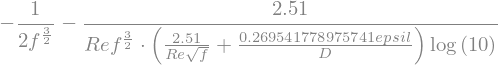

In [15]:
#Find the derivative of the Colbrook equation with SymPy
ff= sym.symbols('f')
Re = sym.symbols('Re')
D = sym.symbols('D')
epsil = sym.symbols('epsil')
#display the symbolic equation
sym.init_printing()
sym.diff(1/sym.sqrt(ff) + 2*sym.log(2.51/(Re*sym.sqrt(ff))+epsil/(3.71*D),10),ff) #the 10 is the base of the log


Below is another example of using Newton's method to solve a non-linear system of equations where the derivatives of each equation with respect to each variable are known and defined in the Jacobian matrix.  A more in-depth class on numerical mehods would explain more.

In [13]:
# Define the system of equations
def equations(x):
    eq1 = x[0]**2 + x[1] - 4
    eq2 = x[0] - x[1]**2 - 1
    return [eq1, eq2]

# Define the Jacobian matrix (partial derivatives with respect to x1 and x2)
def jacobian(x):
    jac = np.array([[2*x[0], 1],
                    [1, -2*x[1]]])
    return jac

# Solve the system of equations using Newton's method
def newton_method(equations, jacobian, x0, tolerance=1e-6, max_iterations=100):
    x = x0
    for i in range(max_iterations):
        f = equations(x)
        J = jacobian(x)
        delta_x = np.linalg.solve(J, -np.array(f))
        x += delta_x
        if np.linalg.norm(delta_x) < tolerance:
            break
    return x

# Initial guess
x0 = np.array([1.0, 1.0])

# Solve the system of equations
solution = newton_method(equations, jacobian, x0)

print("Solution:")
print(solution)

Solution:
[1.76746906 0.87605312]
